## 📸 특징들에 대해 더 알아보기: 물체 검출
이전 장에서는 이미지의 물체를 구분하기 위해서 gradient를 이용하여 edge를 검출하는 것으로 물체를 구분해왔다.  
이 장에서 더 나은 성능을 보이기 위해 다르게 접근해본다.
### 코너란?
코너는 에지의 교차점을 의미한다. 물론 교차점이 4개라고 해서 무조건 탁자라고 섣불리 판단은 할 수 없지만,  
(뭘 분류하느냐에 따라) 최선은 아니되 어느 정도 기준은 될 수가 있다..!

### 해리스 코너(Harris Corner)

In [1]:
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks

<ipython-input-6-d58f38c3bae1>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = rgb2gray(image)
<ipython-input-6-d58f38c3bae1>:4: FutureWarning: Until version 0.16, threshold_rel was set to 0.1 by default. Starting from version 0.16, the default value is set to None. Until version 0.18, a None value corresponds to a threshold value of 0.1. The default behavior will match skimage.feature.peak_local_max. To avoid this warning, set threshold_rel=0.
  coords = corner_peaks(corners, min_distance=5)


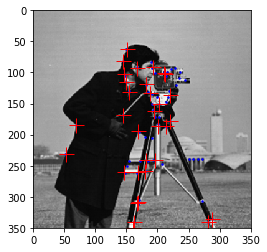

In [6]:
image = imread("test.png")
image = rgb2gray(image)
corners = corner_harris(image) #코너 픽셀일 가능성 측정
coords = corner_peaks(corners, min_distance=5) #실제 코너를 찾는 함수
coords_subpix = corner_subpix(image, coords, window_size=13) # 미세 조정하는데 도움이 되는 함수
fig, ax = plt.subplots()
ax.imshow(image,interpolation="nearest",cmap=plt.cm.gray)
ax.plot(coords[:,1], coords[:,0], ".b", markersize=3)
ax.plot(coords_subpix[:,1], coords_subpix[:,0], "+r",markersize=15)
ax.axis((0,350,350,0))
plt.show()

### 지역 이진 패턴(Local Binary Pattern)
직렬형 분류기, 이미지의 레이블 출력 시 블랙박스와 유사한 특징을 지니고 있다.   
기본적으로 지역 이진 패턴은 이웃하는 8개의 픽셀에서 픽셀 값이 중심 픽셀 값보다 클 경우 1, 아니면 0으로 할당한다.  
(정수형의 사용으로 학습과 테스트가 빠른 편이다. 보통 임베디드 응용프로그램에서 선호)


In [8]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
import numpy as np

In [12]:
brick = data.brick()
grass = data.grass()
wall = data.gravel()

In [18]:
brick_lbp = local_binary_pattern(brick, 16,2,"uniform")
grass_lbp = local_binary_pattern(grass, 16,2,"uniform")
wall_lbp = local_binary_pattern(wall, 16,2,"uniform")

In [19]:
brick_rot = rotate(brick, angle=22, resize=False)
grass_rot = rotate(grass, angle=22, resize=False)
wall_rot = rotate(wall, angle=22, resize=False)

In [20]:
brick_rot_lbp = local_binary_pattern(brick_rot, 16,2,"uniform")
grass_rot_lbp = local_binary_pattern(grass_rot, 16,2,"uniform")
wall_rot_lbp = local_binary_pattern(wall_rot, 16,2,"uniform") 

In [24]:
bins_num = int(brick_lbp.max()+1)
brick_hist, _ = np.histogram(brick_lbp, normed=True,bins=bins_num, range=(0,bins_num))
lbp_features = [brick_rot_lbp, grass_rot_lbp, wall_rot_lbp]
min_score = 1000
winner = 0
idx = 0

<ipython-input-24-8eb46f8c9aaf>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  brick_hist, _ = np.histogram(brick_lbp, normed=True,bins=bins_num, range=(0,bins_num))


In [25]:
for feature in lbp_features:
    histogram, _ = np.histogram(feature, normed=True, bins=bins_num, range=(0,bins_num))
    p = np.asarray(brick_hist)
    q = np.asarray(histogram)
    filter_idx = np.logical_and(p!=0, q!=0)
    score = np.sum(p[filter_idx]*np.log2(p[filter_idx] / q[filter_idx]))    #Kullback Leibler Divergence 계산
    if score < min_score:
        min_score = score
        winner = idx
    idx = idx + 1
if winner == 0:
    print("Brick matched with Brick Rotated")
elif winner == 1:
    print("Brick matched with Grass Rotated")
elif winner == 2:
    print("Brick matched with Wall Rotated")

Brick matched with Brick Rotated


<ipython-input-25-cbb0b36879c8>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  histogram, _ = np.histogram(feature, normed=True, bins=bins_num, range=(0,bins_num))


### ORB